# Capstone Project: Police Call Outcome Prediction: Year 2020

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings, os, sys
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2020 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
years = [2020]
year = "2020"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 297458


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
113562,20200519175629PD,8163306,5/15/2021 12:00:00 AM,P201400799,4,5/19/2020 12:00:00 AM,5/19/2020 12:00:00 AM,17:05:16,22500,PARKING VIOLATION,CAN,Canceled,[2100]-[2200] EVELYN AV,San Jose,CA,37.337264,-121.827011,Hillview
100934,20200504115025PD,8143008,5/15/2021 12:00:00 AM,P201250433,4,5/4/2020 12:00:00 AM,5/4/2020 12:00:00 AM,11:50:25,911UNK,UNK TYPE 911 CALL,ADV,No Disposition,SILVER CREEK RD & ASHRIDGE LN,San Jose,CA,37.303504,-121.803738,Silver Creek High School
158780,20200712141449PD,8232300,5/15/2021 12:00:00 AM,P201940552,2,7/12/2020 12:00:00 AM,7/12/2020 12:00:00 AM,13:39:29,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[100]-[200] S 26TH ST,San Jose,CA,37.350261,-121.867991,Five Wounds-San Jose High
34070,20200210124934PS,8034622,5/15/2021 12:00:00 AM,P200410331,4,2/10/2020 12:00:00 AM,2/10/2020 12:00:00 AM,10:13:50,22500,PARKING VIOLATION,E,"Traffic Citation Issued, Non-H",[0]-[100] KENBROOK CL,San Jose,CA,NaN,NaN,NaN
131501,20200611112436PD,8191565,5/15/2021 12:00:00 AM,P201630328,3,6/11/2020 12:00:00 AM,6/11/2020 12:00:00 AM,10:43:24,459R,BURGLARY REPORT (460),R,Report taken,[100]-[200] BRANHAM LN,San Jose,CA,37.251638,-121.908405,Branham


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297458 entries, 0 to 297457
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              297458 non-null  object 
 1   EID               297458 non-null  int64  
 2   START_DATE        297458 non-null  object 
 3   CALL_NUMBER       297458 non-null  object 
 4   PRIORITY          297458 non-null  int64  
 5   REPORT_DATE       297458 non-null  object 
 6   OFFENSE_DATE      297458 non-null  object 
 7   OFFENSE_TIME      297458 non-null  object 
 8   CALLTYPE_CODE     297458 non-null  object 
 9   CALL_TYPE         297458 non-null  object 
 10  FINAL_DISPO_CODE  297458 non-null  object 
 11  FINAL_DISPO       297458 non-null  object 
 12  ADDRESS           289264 non-null  object 
 13  CITY              297458 non-null  object 
 14  STATE             297458 non-null  object 
 15  LATITUDE          268162 non-null  float64
 16  LONGITUDE         26

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,2.974580e+05,297458.000000,268162.000000,268162.000000
mean,8.214560e+06,3.217372,37.321590,-121.870947
std,1.335097e+05,1.340462,0.042648,0.047266
min,7.981564e+06,1.000000,37.150332,-122.035696
25%,8.097296e+06,2.000000,37.298380,-121.901964
50%,8.217202e+06,3.000000,37.324817,-121.869217
75%,8.329770e+06,4.000000,37.349285,-121.838443
max,8.444831e+06,6.000000,37.534539,-121.684849


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,297458,297458,297458,297458,297458,297458,297458,297458,297458,297458,289264,297458,297458,266914
unique,295605,1,291644,366,366,80359,209,202,22,18,30712,1,1,295
top,20201210081815PS,5/15/2021 12:00:00 AM,P201410580,7/4/2020 12:00:00 AM,7/4/2020 12:00:00 AM,13:02:40,415,DISTURBANCE,N,No report required; dispatch r,[200]-[300] W MISSION ST,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,297458,5,1028,1028,15,32688,32688,144108,144108,1062,297458,297458,8591


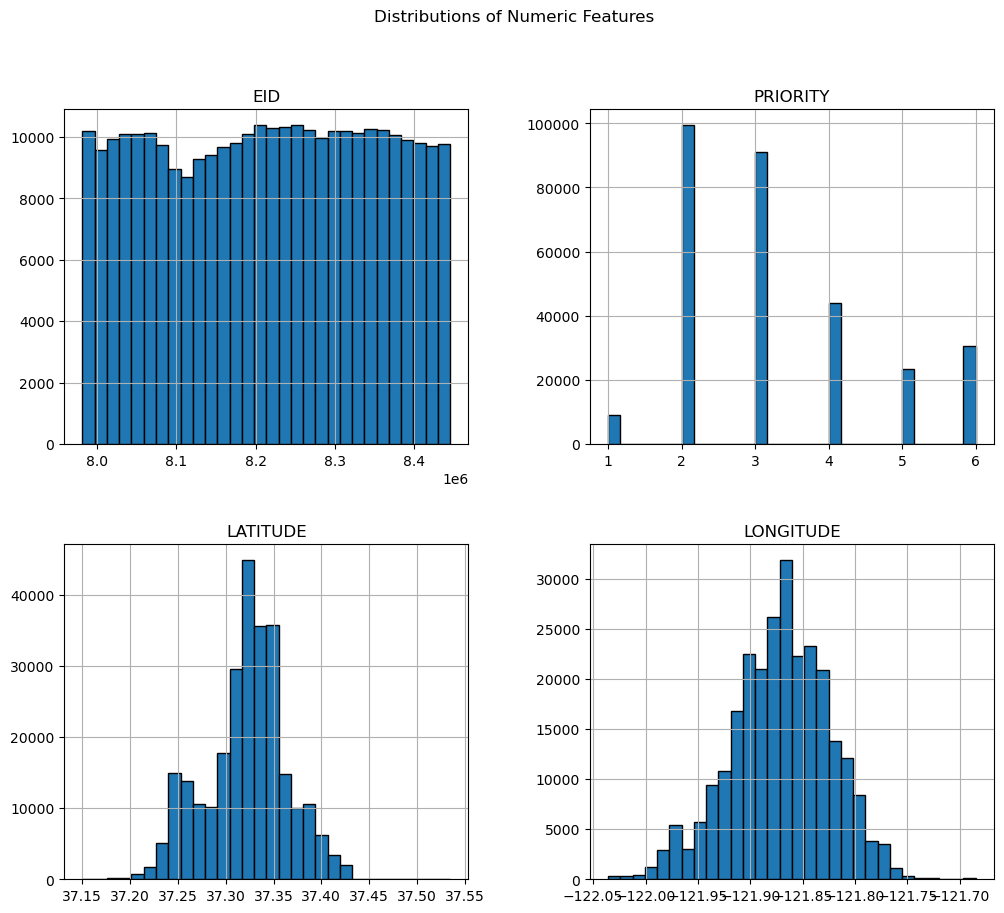

In [11]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [12]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              8194
CITY                    0
STATE                   0
LATITUDE            29296
LONGITUDE           29296
neighborhood        30544
dtype: int64

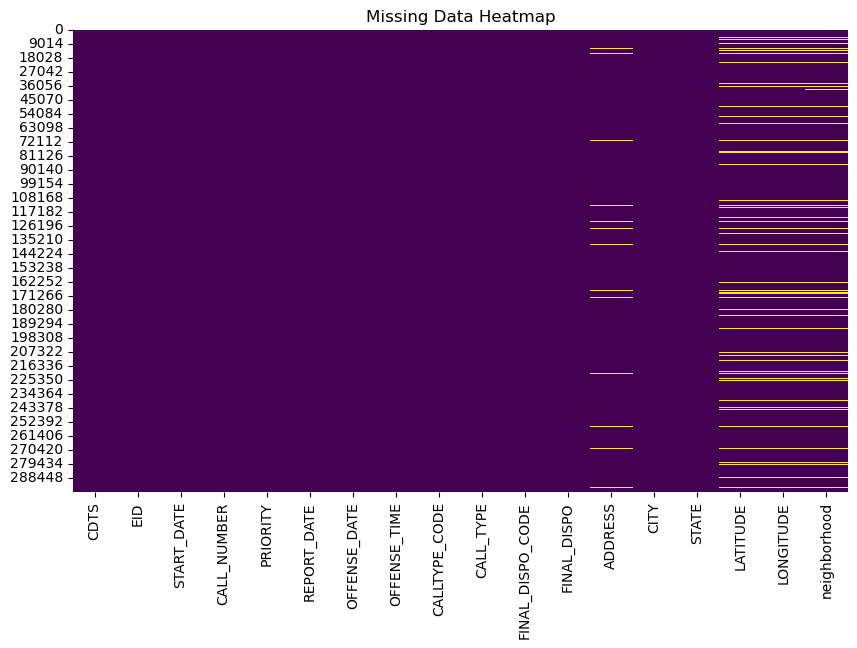

In [13]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [14]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 295605 unique values
START_DATE: 1 unique values
CALL_NUMBER: 291644 unique values
REPORT_DATE: 366 unique values
OFFENSE_DATE: 366 unique values
OFFENSE_TIME: 80359 unique values
CALLTYPE_CODE: 209 unique values
CALL_TYPE: 202 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 30712 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [15]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8591
Little Saigon and Spring Brook    5019
Five Wounds-San Jose High         4721
Fruitdale and Sherman Oaks        4203
Trimble Business Area             4175
                                  ... 
Los Alamitos Creek                  43
Linda Vista and Hillcrest           40
Alta Vista                          30
Santa Teresa Hills                  25
Meadowlands                         18
Name: count, Length: 295, dtype: int64

In [16]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          144108
CAN         46235
R           32361
G           18642
E            6880
O            6726
DUPNCAN      5551
D            5236
A            5212
H            4294
U            4292
GD           4181
C            3236
T            3038
ADV          2864
B            2059
NR           1487
F             906
Z              54
P              45
M              42
TOT             9
Name: count, dtype: int64

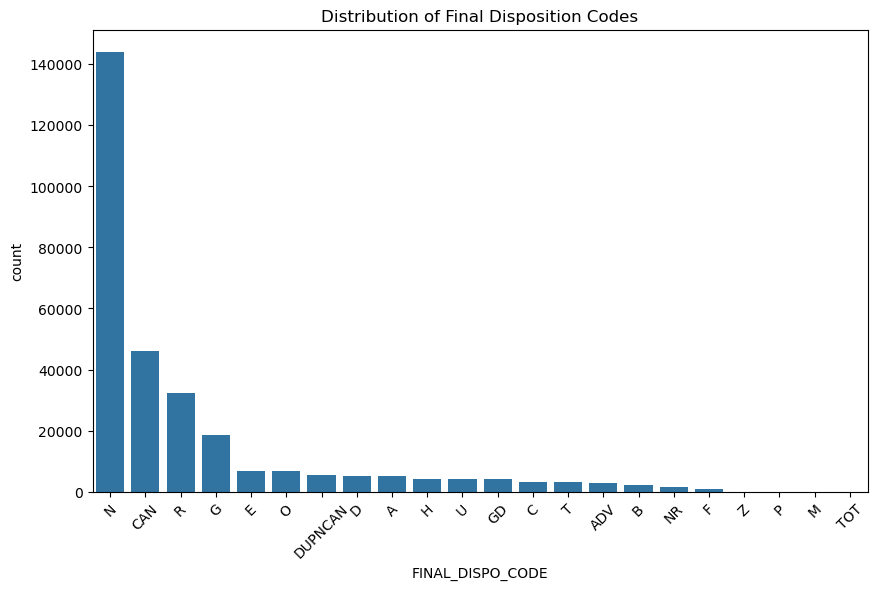

In [17]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [18]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    144108
Canceled                           46235
Report taken                       32361
Gone on Arrival/unable to loca     18642
No Disposition                     12659
Traffic Citation Issued, Non-H      6880
Supplemental report taken           6726
Traffic Citation Issued, Hazar      5236
Arrest Made                         5212
Courtesy Service/Citizen or ag      4294
Unfounded event                     4292
Criminal Citation                   3236
Turned over To (TOT)                3038
Arrest by Warrant                   2059
No Response                         1487
Field Interview (F.I.) Complet       906
Prior case, follow-up activity        45
Stranded motorist assist              42
Name: count, dtype: int64

In [19]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'CAN': 'Canceled',
 'GD': 'No Disposition',
 'U': 'Unfounded event',
 'G': 'Gone on Arrival/unable to loca',
 'NR': 'No Response',
 'R': 'Report taken',
 'DUPNCAN': 'No Disposition',
 'A': 'Arrest Made',
 'O': 'Supplemental report taken',
 'D': 'Traffic Citation Issued, Hazar',
 'T': 'Turned over To (TOT)',
 'E': 'Traffic Citation Issued, Non-H',
 'M': 'Stranded motorist assist',
 'H': 'Courtesy Service/Citizen or ag',
 'C': 'Criminal Citation',
 'ADV': 'No Disposition',
 'B': 'Arrest by Warrant',
 'F': 'Field Interview (F.I.) Complet',
 'P': 'Prior case, follow-up activity',
 'TOT': 'No Disposition',
 'Z': 'No Disposition'}

In [20]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1057': 'FIREARMS DISCHARGED',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1095': 'PEDESTRIAN STOP',
 '415': 'DISTURBANCE',
 '10851': 'STOLEN VEHICLE',
 '246': 'SHOOTING INTO OCCP VEH OR DWEL',
 'WELCK': 'WELFARE CHECK',
 '23103': 'RECKLESS DRIVING',
 '23152': 'MISDEMEANOR DUI',
 '422': 'CRIMINAL THREATS',
 '415A': 'DISTURBANCE, FIGHT',
 '602PC': 'TRESPASSING',
 '415F': 'DISTURBANCE, FAMILY',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 '488': 'PETTY THEFT',
 '1066P': 'SUSPICIOUS PACKAGE',
 '148': 'RESISTING ARREST',
 '415N': 'DISTURBANCE, NEIGHBOR',
 '911UNK': 'UNK TYPE 911 CALL',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '242EMS': 'BATTERY (COMBINED EVENT)',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '211SA': 'STRONG ARM ROBBERY',
 '22500': 'PARKING VIOLATION',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '1066W': 'SUSPICIOUS PERSON W/ WEAPON',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '459VEH': 'VEHICLE BU

## Focus on Target Dispositions

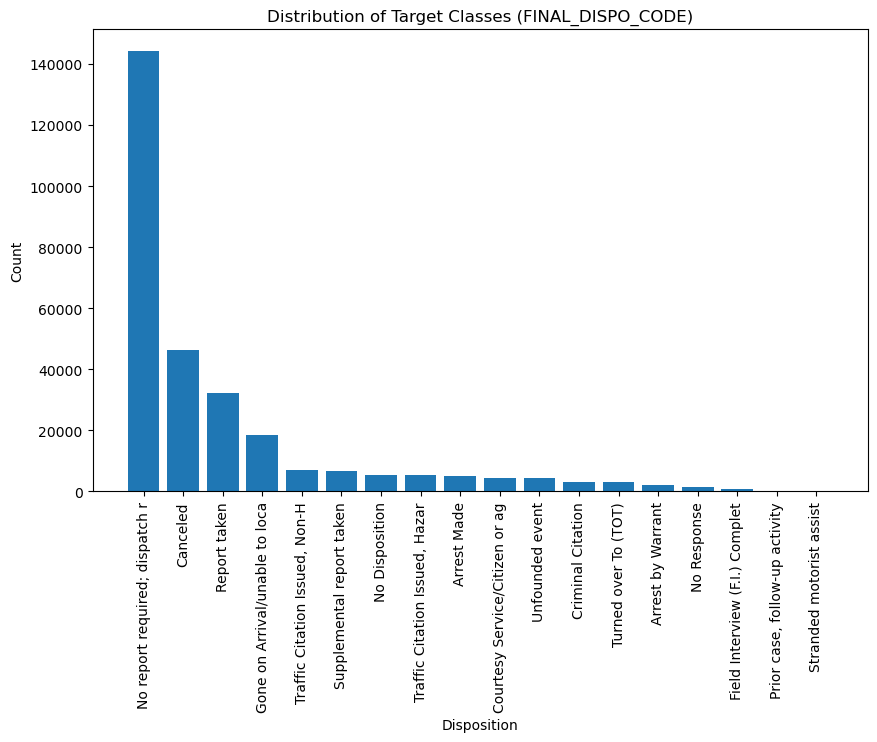

In [23]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [24]:
model_utils.transform_offense_date(all_police_df)

In [25]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    286951
A          5212
C          3236
B          2059
Name: count, dtype: int64

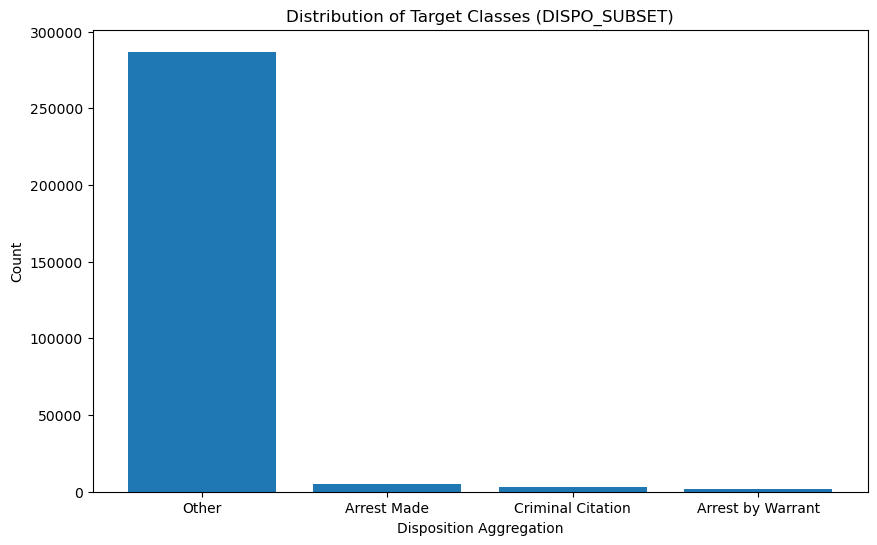

In [26]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [32]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 297458 rows before cleaning, 266914 rows after cleaning.


In [33]:
police_calls_encoded.shape

(266914, 15)

In [34]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,3,1033A,0.611311,1.450922,Boeger and Fernish Park,0,2,1,2020,No,Other,0.084499,0.373701,0.886964,2.105174
1,4,415M,0.101367,0.078441,Virginia and Martha,0,2,1,2020,No,Other,0.022953,0.010275,0.007951,0.006153
2,2,AID,-2.218806,2.083276,Los Paseos,0,2,1,2020,No,Other,0.158973,4.923101,-4.622385,4.340037
3,2,AID,-2.218806,2.083276,Los Paseos,0,2,1,2020,No,Other,0.158973,4.923101,-4.622385,4.340037
4,2,1057,-1.797300,0.126558,Steinbeck and Allen,0,2,1,2020,No,Other,0.095612,3.230289,-0.227463,0.016017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297452,4,415M,-0.693624,0.928117,Andrew Hill and Sylvandale,0,3,12,2020,Yes,Other,0.075191,0.481115,-0.643765,0.861401
297453,4,415FC,-1.187137,0.893223,Skyway and Monterey,0,3,12,2020,Yes,Other,0.088554,1.409293,-1.060378,0.797848
297455,4,415M,-0.036441,-0.499032,Gardner,0,3,12,2020,Yes,Other,0.019761,0.001328,0.018185,0.249033
297456,4,415,0.746670,1.491546,Calico Creek,0,3,12,2020,Yes,Other,0.087216,0.557517,1.113693,2.224710


## Define X and Y

In [37]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [39]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(213531, 14)
(53383, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 205864, 0: 3838, 2: 2323, 1: 1506})
Counter({3: 7667, 0: 3838, 2: 2323, 1: 1506})


In [41]:
X_train.shape

(213531, 529)

In [42]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
19672,-0.910532,0.191799,0.497689,-0.534814,-0.695263,0.237431,-0.519344,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134097,-0.910532,-0.291298,0.995426,0.315199,-0.660494,-0.107750,-0.005812,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
147638,-0.165656,0.625405,0.852190,-0.044698,-0.439569,0.629134,-0.188664,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197798,-0.165656,0.146583,0.807798,-0.103134,-0.706300,0.257931,-0.239581,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149738,-0.165656,0.394149,0.616877,-0.396378,-0.609715,0.369672,-0.427536,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28228,-0.910532,-0.576040,-0.356386,-0.502618,-0.482193,0.335578,-0.603118,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271242,0.579220,-1.387094,-0.160533,0.523873,0.667167,0.350858,-0.672944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
162212,-0.165656,1.954878,-1.509991,0.833651,2.036251,-2.489356,0.883354,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
229136,0.579220,2.175491,0.033611,0.577962,2.693918,0.218117,-0.689867,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


y_train distribution: Counter({3: 205864, 0: 3838, 2: 2323, 1: 1506})
y_test distribution: Counter({3: 51466, 0: 959, 2: 581, 1: 377})
y_train_resampled distribution: Counter({3: 205864, 0: 3838, 2: 2323, 1: 1506})


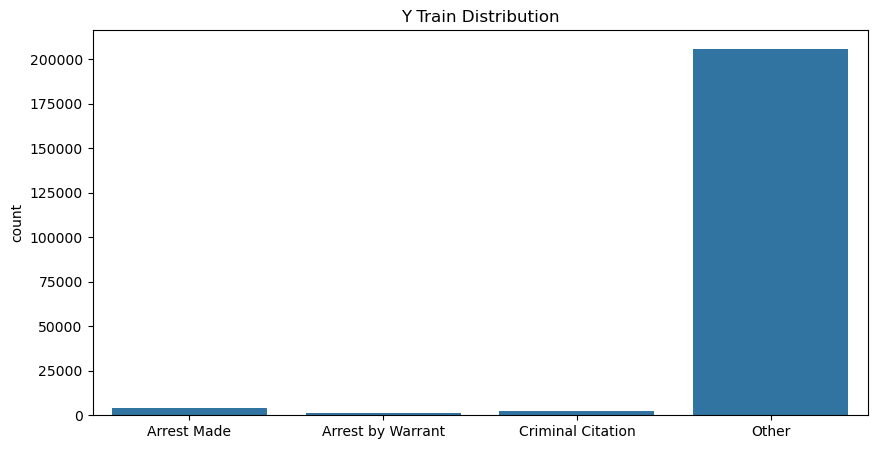

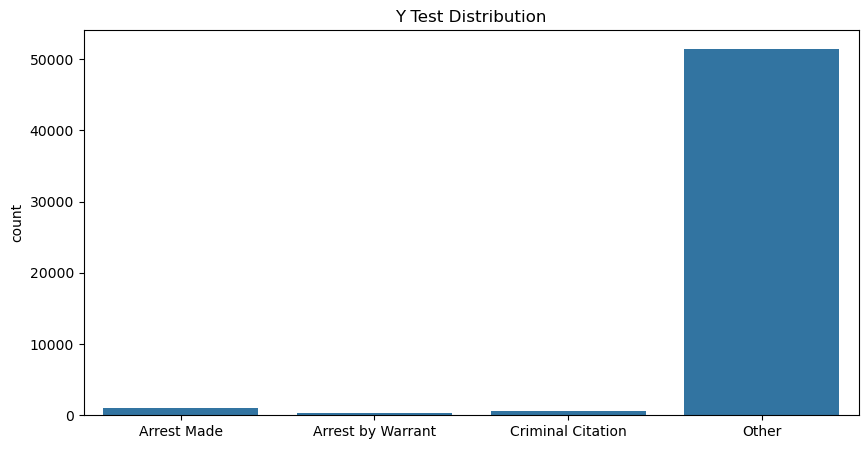

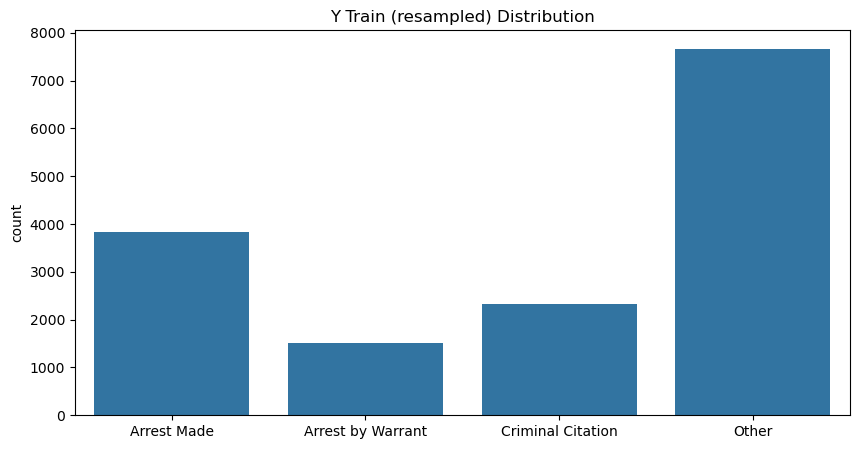

In [43]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [46]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [47]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [48]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       959
Arrest by Warrant       0.00      0.00      0.00       377
Criminal Citation       0.00      0.00      0.00       581
            Other       0.96      1.00      0.98     51466

         accuracy                           0.96     53383
        macro avg       0.24      0.25      0.25     53383
     weighted avg       0.93      0.96      0.95     53383



### Logistic Regression

In [50]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [51]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [52]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.15      0.62      0.24       959
Arrest by Warrant       0.55      0.61      0.57       377
Criminal Citation       0.16      0.52      0.24       581
            Other       0.99      0.91      0.95     51466

         accuracy                           0.90     53383
        macro avg       0.46      0.66      0.50     53383
     weighted avg       0.96      0.90      0.92     53383



#### Hyperparameter Tuning

In [58]:
grid_search_scoring_method = 'f1_macro'

In [59]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [64]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5643


In [66]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2020/best_logistic_regression.pkl']

In [69]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [71]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.22      0.32       959
Arrest by Warrant       0.67      0.55      0.61       377
Criminal Citation       0.43      0.27      0.33       581
            Other       0.98      0.99      0.99     51466

         accuracy                           0.97     53383
        macro avg       0.67      0.51      0.56     53383
     weighted avg       0.96      0.97      0.96     53383



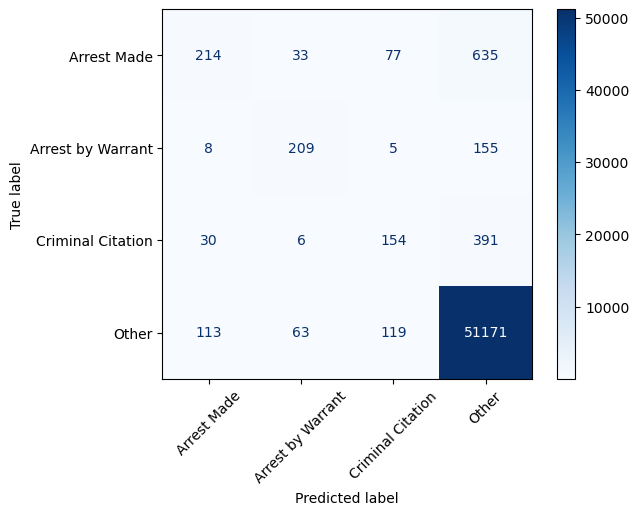

In [76]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [78]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [79]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [80]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.014456
1,neighborhood,0.000531
5,DISTANCE_FROM_CENTER,0.000406
3,LATITUDE,0.000187
2,PRIORITY,0.000156
7,LATITUDE LONGITUDE,0.000031
8,LONGITUDE^2,0.000031
9,AFTER_COVID_Yes,-0.000031
6,LATITUDE^2,-0.000062
4,LONGITUDE,-0.000187


In [83]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [85]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                               Feature  Importance  \
200                                   CALLTYPE_CODE_6M    0.002904   
199                                   CALLTYPE_CODE_6F    0.002029   
59                                 CALLTYPE_CODE_11300    0.001093   
184                                 CALLTYPE_CODE_601T    0.000687   
64                                 CALLTYPE_CODE_11377    0.000562   
61                                 CALLTYPE_CODE_11350    0.000562   
107                                CALLTYPE_CODE_23152    0.000531   
102                                CALLTYPE_CODE_22500    0.000468   
232                                CALLTYPE_CODE_WELCK    0.000437   
80                                 CALLTYPE_CODE_12020    0.000437   
84                                 CALLTYPE_CODE_14601    0.000406   
3                                 DISTANCE_FROM_CENTER    0.000406   
136                                  CALLTYPE_CODE_415    0.000375   
65                  

In [86]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.313985
107                 Call Type: MISDEMEANOR DUI     2.743163
82      Call Type: CARRYING A CONCEALED WEAPON     2.706104
131                Call Type: PAROLE VIOLATION     2.634702
196                 Call Type: DRUNK IN PUBLIC     2.503544
87   Call Type: RESISTING ARREST, GANG RELATED     2.498204
72   Call Type: VEHICLE ACCIDENT, PROPERTY DAM    -2.385026
225   Call Type: VIOLATION OF PROTECTIVE ORDER     2.294903
8                    Call Type: ALARM, AUDIBLE    -2.268537
108                      Call Type: FELONY DUI     2.254023
206               Call Type: UNK TYPE 911 CALL    -2.139528
148              Call Type: DISTURBANCE, MUSIC    -2.115821
117           Call Type: BATTERY ON AN OFFICER     2.081790
102               Call Type: PARKING VIOLATION    -2.030323
109              Call Type: FALSE IMPRISONMENT     2.027753
129    Call Type: R

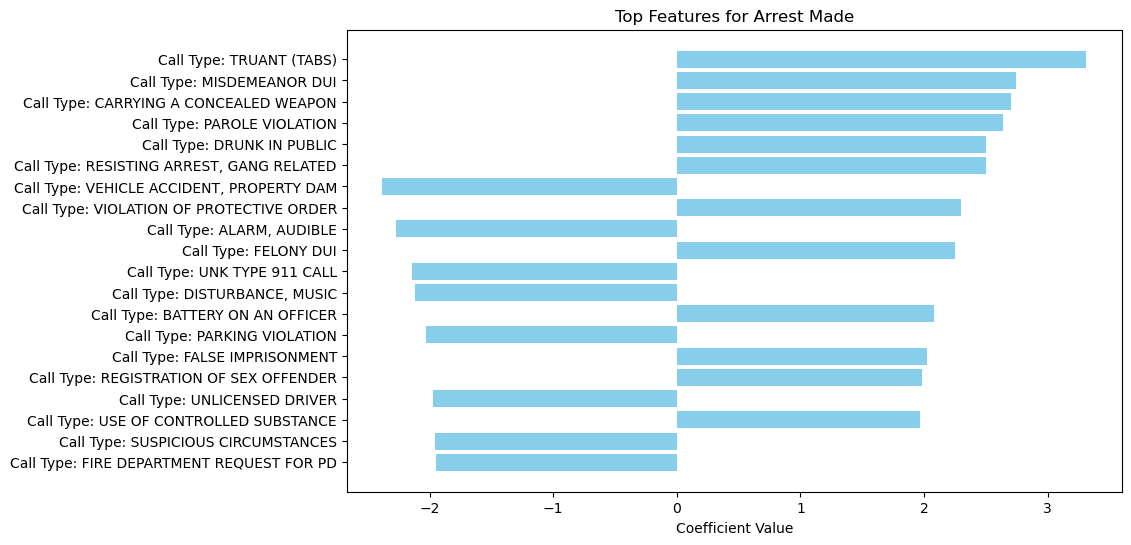

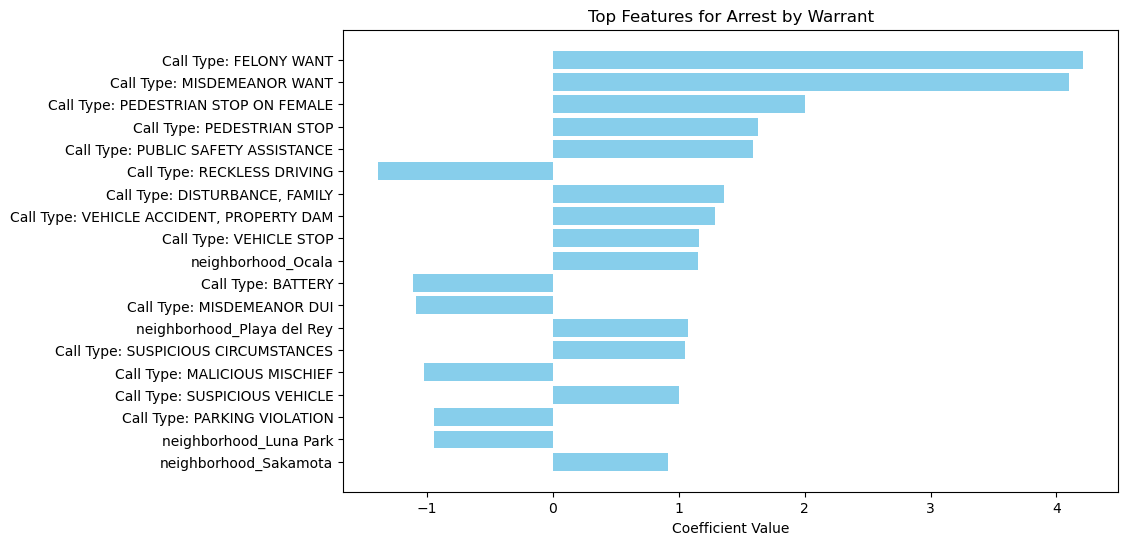

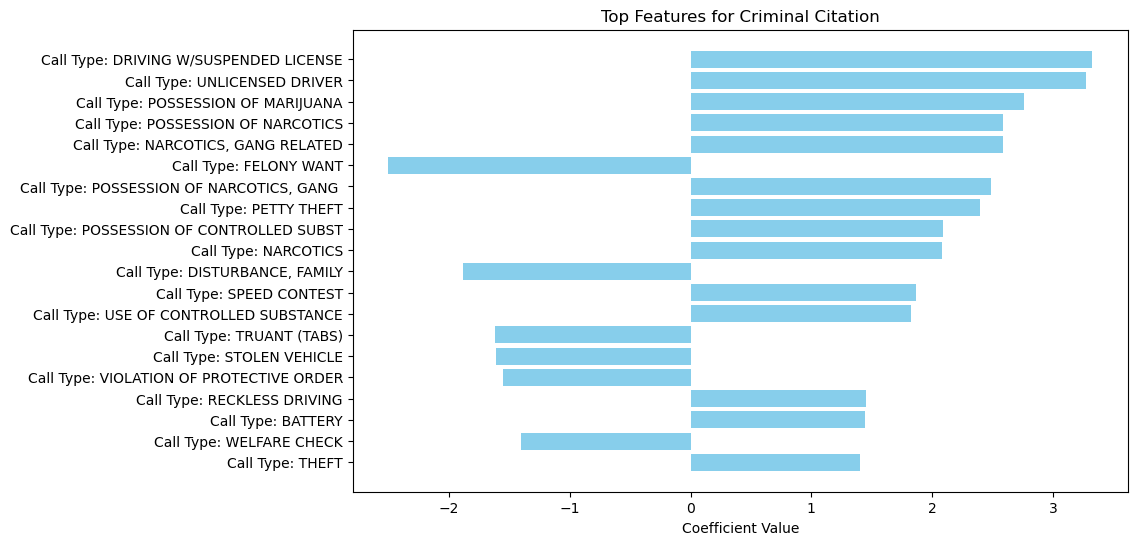

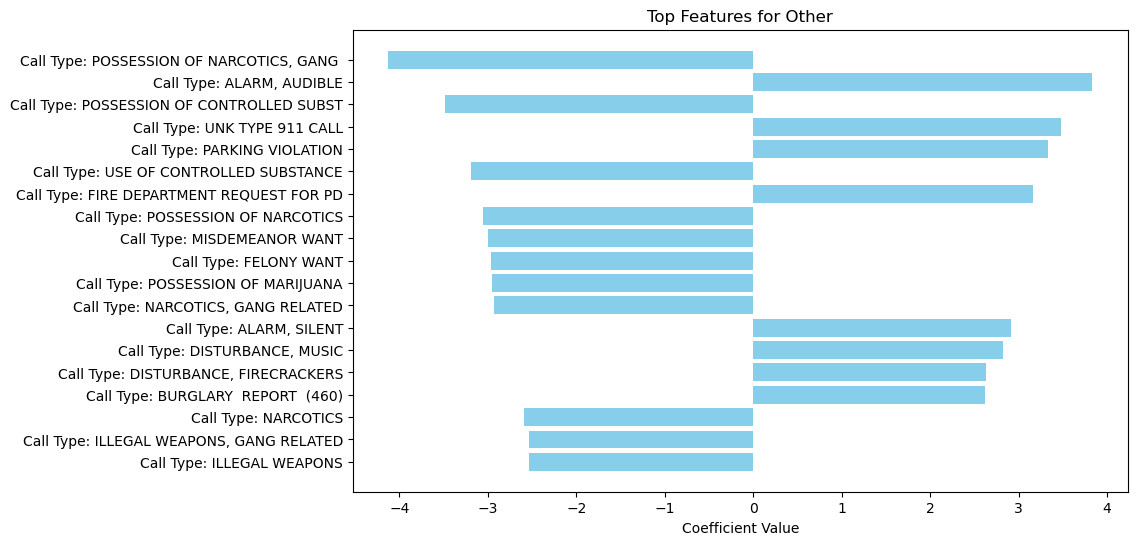

In [90]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [93]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [94]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.45      0.26      0.33       959
Arrest by Warrant       0.64      0.46      0.54       377
Criminal Citation       0.36      0.23      0.28       581
            Other       0.98      0.99      0.98     51466

         accuracy                           0.97     53383
        macro avg       0.61      0.49      0.53     53383
     weighted avg       0.96      0.97      0.96     53383



#### Hyperparameter Tuning and Cross Validation

In [96]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.53


In [97]:
best_rf = grid_rf.best_estimator_

In [98]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2020/best_random_forest.pkl']

In [99]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [100]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.45      0.26      0.33       959
Arrest by Warrant       0.63      0.44      0.51       377
Criminal Citation       0.37      0.23      0.28       581
            Other       0.98      0.99      0.98     51466

         accuracy                           0.97     53383
        macro avg       0.60      0.48      0.53     53383
     weighted avg       0.96      0.97      0.96     53383



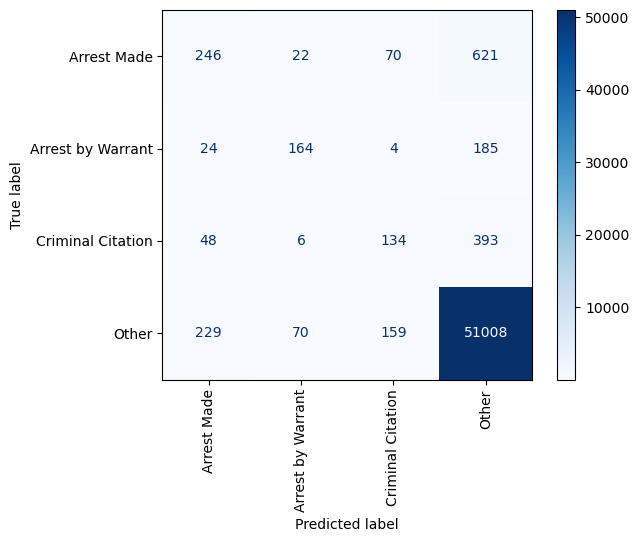

In [101]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [102]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 13:01:37,621] A new study created in memory with name: no-name-7270f146-2ecd-458b-8c0c-673b658065a6
[I 2024-10-08 13:01:38,721] Trial 0 finished with value: 0.5492976460042092 and parameters: {'n_estimators': 94, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5492976460042092.
[I 2024-10-08 13:01:39,882] Trial 1 finished with value: 0.6739526180833142 and parameters: {'n_estimators': 68, 'max_depth': 66, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6739526180833142.
[I 2024-10-08 13:01:40,623] Trial 2 finished with value: 0.2253282942780001 and parameters: {'n_estimators': 79, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.6739526180833142.
[I 2024-10-08 13:01:41,856] Trial 3 finished with value: 0.6610992308221038 and parameters: {'n_estimators': 78, 'max_depth': 39, 'mi

Best hyperparameters: {'n_estimators': 51, 'max_depth': 87, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [103]:
best_params = study.best_params
best_params

{'n_estimators': 51,
 'max_depth': 87,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [104]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=87, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=51, n_jobs=-1)

In [105]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.18      0.28       959
Arrest by Warrant       0.70      0.59      0.64       377
Criminal Citation       0.46      0.21      0.29       581
            Other       0.98      1.00      0.99     51466

         accuracy                           0.97     53383
        macro avg       0.70      0.50      0.55     53383
     weighted avg       0.96      0.97      0.96     53383



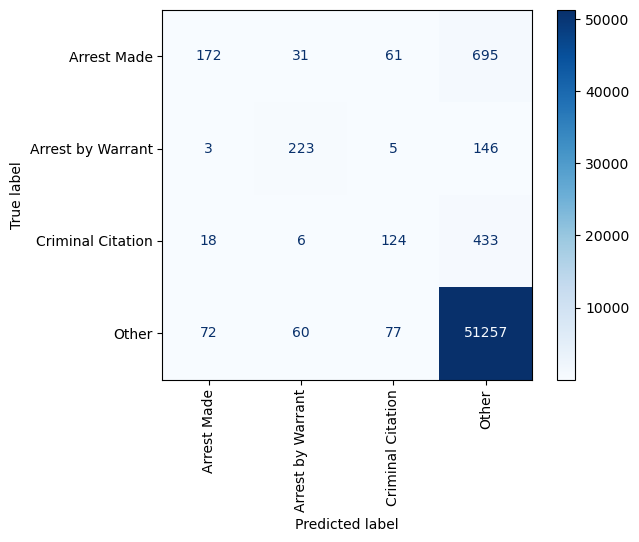

In [109]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

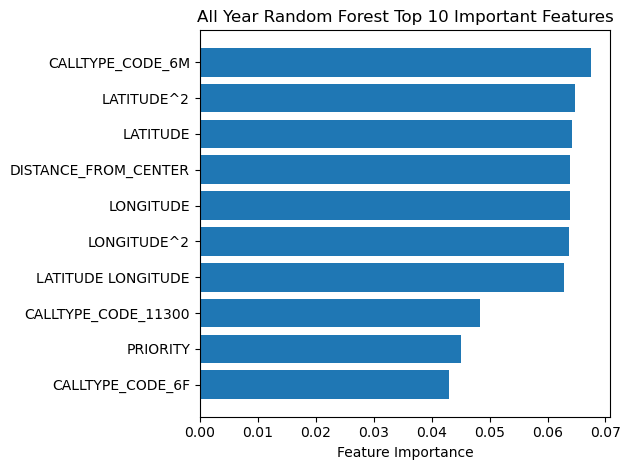

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [114]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [115]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9627 - loss: 0.1721 - val_accuracy: 0.9678 - val_loss: 0.1165
Epoch 2/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9700 - loss: 0.1145 - val_accuracy: 0.9684 - val_loss: 0.1160
Epoch 3/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9699 - loss: 0.1127 - val_accuracy: 0.9673 - val_loss: 0.1155
Epoch 4/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9709 - loss: 0.1068 - val_accuracy: 0.9688 - val_loss: 0.1163
Epoch 5/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9718 - loss: 0.1050 - val_accuracy: 0.9675 - val_loss: 0.1155
Epoch 6/20
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9729 - loss: 0.0985 - val_accuracy: 0.9681 - val_loss: 0.1220


In [117]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2020/mlp_model.pkl']

In [118]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [119]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1669/1669 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.9687 - loss: 0.1137
Test Accuracy: 0.9690


In [120]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1669/1669 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.57      0.31      0.40       959
Arrest by Warrant       0.67      0.51      0.58       377
Criminal Citation       0.38      0.04      0.07       581
            Other       0.98      1.00      0.99     51466

         accuracy                           0.97     53383
        macro avg       0.65      0.46      0.51     53383
     weighted avg       0.96      0.97      0.96     53383



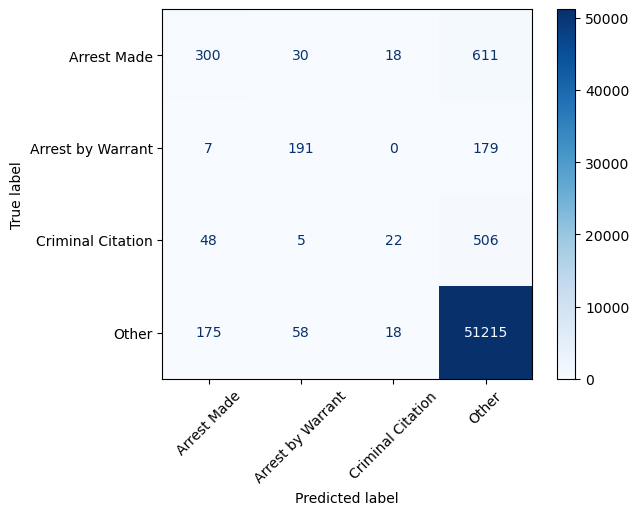

In [121]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [124]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 13:02:53,077] A new study created in memory with name: no-name-294a44d9-fa58-4d8b-a7e1-458c06023e2c
[I 2024-10-08 13:03:15,455] Trial 0 finished with value: 0.6404260618453052 and parameters: {'learning_rate': 0.4854833640598266, 'max_depth': 8, 'subsample': 0.7383273013499213, 'colsample_bytree': 0.7049244055239008, 'gamma': 1.3525694644813514e-07, 'reg_alpha': 4.44226136670952e-05, 'reg_lambda': 0.2048698958530894}. Best is trial 0 with value: 0.6404260618453052.
[I 2024-10-08 13:03:29,331] Trial 1 finished with value: 0.6829155495063481 and parameters: {'learning_rate': 0.059281712224578065, 'max_depth': 3, 'subsample': 0.6249830409717031, 'colsample_bytree': 0.9539479745290576, 'gamma': 0.0010274290104144957, 'reg_alpha': 1.0346920081933349e-08, 'reg_lambda': 0.0004445059642970996}. Best is trial 1 with value: 0.6829155495063481.
[I 2024-10-08 13:03:50,899] Trial 2 finished with value: 0.6812575703666239 and parameters: {'learning_rate': 0.02487535356511888, 'max_dept

Actual runtime: 437.17 seconds (7.29 minutes)
Best parameters found:  {'learning_rate': 0.1037601253044546, 'max_depth': 3, 'subsample': 0.9892196128882433, 'colsample_bytree': 0.8981060800202232, 'gamma': 0.004296844662997074, 'reg_alpha': 1.7628038338405717e-06, 'reg_lambda': 2.0023060650807226e-08}
Best F1 macro score:  0.6881263501938036


In [125]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8981060800202232, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.004296844662997074, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1037601253044546, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.73      0.04      0.08       959
Arrest by Warrant       0.68      0.56      0.62       377
Criminal Citation       0.49      0.09      0.16       581
            Other       0.97      1.00      0.98     51466

         accuracy                           0.97     53383
        macro avg       0.72      0.42      0.46     53383
     weighted avg       0.96      0.97      0.96     53383



In [127]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2020/xgb_model.pkl']

In [128]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [130]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [131]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.56141590517574
RF F1: 0.5266781842704688
XGB F1: 0.4595615563569886


In [132]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [133]:
best_rf

RandomForestClassifier(n_estimators=60)

In [134]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8981060800202232, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.004296844662997074, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1037601253044546, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [136]:
X_train_float = X_train.astype('float64')

In [137]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8981060800202232,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [138]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2020/stacking_2.pkl']

In [139]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [140]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5751259027627376


In [141]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.29      0.38       959
Arrest by Warrant       0.69      0.57      0.62       377
Criminal Citation       0.44      0.24      0.31       581
            Other       0.98      0.99      0.99     51466

         accuracy                           0.97     53383
        macro avg       0.67      0.52      0.58     53383
     weighted avg       0.96      0.97      0.97     53383



## Results

In [143]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.964090,0.250000,0.241022,0.245429
Logistic Regression,0.969372,0.509214,0.667393,0.561416
Random Forest,0.965701,0.478317,0.604459,0.526678
MLP,0.968998,0.463111,0.648301,0.508712
XGB,0.967780,0.424376,0.717337,0.459562
Ensemble,0.969728,0.521565,0.669828,0.575126


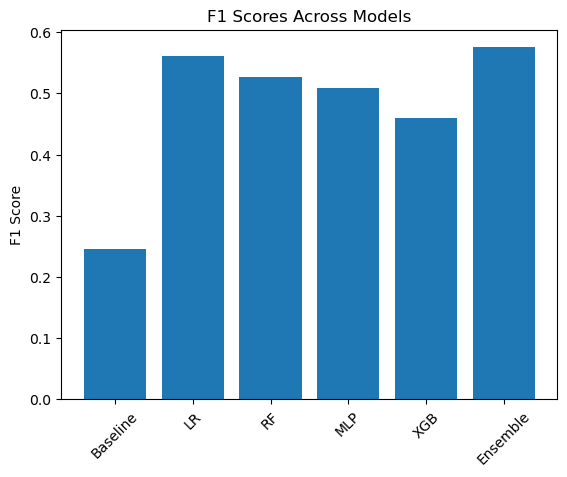

In [144]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [146]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [147]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

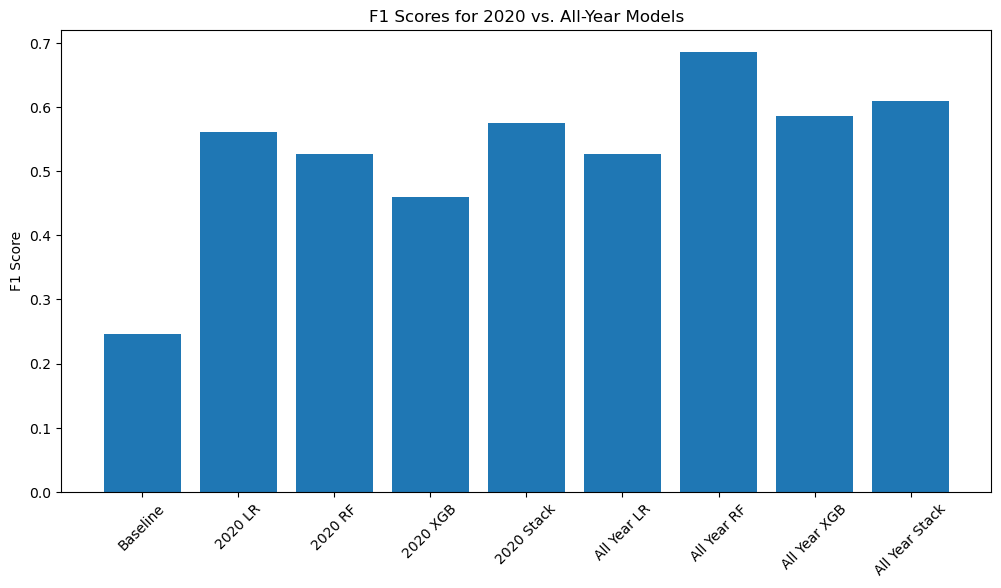

In [148]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2020 vs. Non-2020 Models

In [150]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]

In [151]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(297458, 24)

In [152]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3289399 rows before cleaning, 2933522 rows after cleaning.


(2933522, 15)

In [153]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2346817, 14)
(586705, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2250935, 0: 48758, 2: 26358, 1: 20766})
Counter({3: 95882, 0: 48758, 2: 26358, 1: 20766})


In [154]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [155]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2020 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.37      0.44     12189
Arrest by Warrant       0.70      0.53      0.60      5192
Criminal Citation       0.47      0.23      0.31      6590
            Other       0.98      0.99      0.98    562734

         accuracy                           0.97    586705
        macro avg       0.68      0.53      0.59    586705
     weighted avg       0.96      0.97      0.96    586705



In [156]:
y_pred_rf_oy_2020 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2020, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2020 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.53      0.30      0.38       959
Arrest by Warrant       0.68      0.50      0.58       377
Criminal Citation       0.44      0.20      0.27       581
            Other       0.98      0.99      0.99     51466

         accuracy                           0.97     53383
        macro avg       0.66      0.50      0.56     53383
     weighted avg       0.96      0.97      0.96     53383



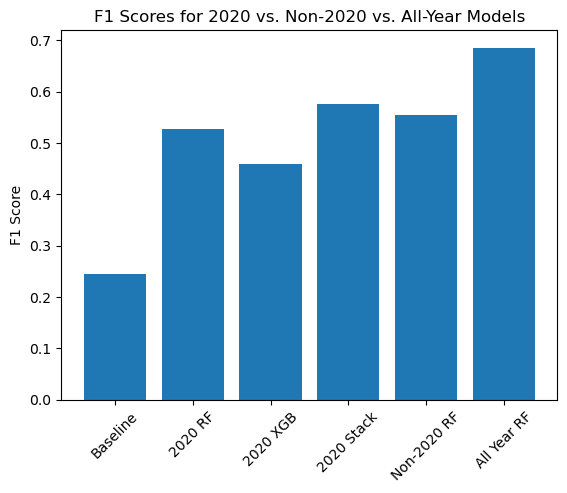

In [157]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2020, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()